In [135]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Q-learning in the wild (3 pts)

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [136]:
import random
import numpy as np
from collections import defaultdict

def make_hashable(state):
    if isinstance(state, dict):
        return tuple(sorted((k, make_hashable(v)) for k, v in state.items()))
    elif isinstance(state, list):
        return tuple(make_hashable(x) for x in state)
    elif isinstance(state, np.ndarray):
        return tuple(state.flatten())
    else:
        return state

class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, getLegalActions):
        self.getLegalActions = getLegalActions
        self._qValues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def getQValue(self, state, action):
        state_key = make_hashable(state)
        if state_key not in self._qValues or action not in self._qValues[state_key]:
            return 0.0
        return self._qValues[state_key][action]

    def setQValue(self, state, action, value):
        state_key = make_hashable(state)
        self._qValues[state_key][action] = value

    def getValue(self, state):
        possibleActions = self.getLegalActions(state)
        if len(possibleActions) == 0:
            return 0.0
        return max([self.getQValue(state, action) for action in possibleActions])

    def getPolicy(self, state):
        possibleActions = self.getLegalActions(state)
        if len(possibleActions) == 0:
            return None
        best_q_value = self.getValue(state)
        best_actions = [action for action in possibleActions
                        if abs(self.getQValue(state, action) - best_q_value) < 1e-10]
        return random.choice(best_actions)

    def getAction(self, state):
        possibleActions = self.getLegalActions(state)
        if len(possibleActions) == 0:
            return None
        if random.random() < self.epsilon:
            return random.choice(possibleActions)
        return self.getPolicy(state)

    def update(self, state, action, nextState, reward):
        current_q = self.getQValue(state, action)
        next_max_q = self.getValue(nextState)
        new_q = current_q + self.alpha * (reward + self.discount * next_max_q - current_q)
        self.setQValue(state, action, new_q)


In [137]:
import gymnasium as gym
env = gym.make("CartPole-v1")
n_actions = env.action_space.n

In [138]:
def play_and_train(env, agent, t_max=10**4):
    total_reward = 0.0
    state, _ = env.reset()

    for t in range(t_max):
        action = agent.getAction(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        agent.update(state, action, next_state, reward)

        state = next_state
        total_reward += reward
        if done:
            break

    return total_reward


In [139]:
agent = QLearningAgent(alpha=0.15,epsilon=0.15,discount=0.96,
                       getLegalActions = lambda s: range(n_actions))

Достигните положительной награды, постройте график

In [140]:
from IPython.display import clear_output


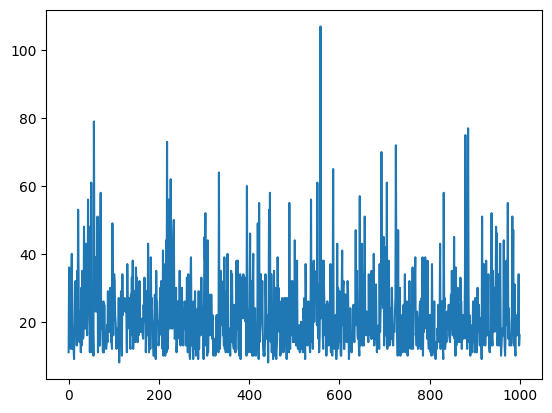

16.0


In [141]:
from IPython.display import clear_output

initial_epsilon = 0.5
final_epsilon = 0.015
decay_rate = 0.997


rewards = []
epsilon_history = []
for i in range(1000):
    rewards.append(play_and_train(env,agent))
    agent.epsilon = max(final_epsilon, initial_epsilon * (decay_rate ** i))
    epsilon_history.append(agent.epsilon)
    if i % 100 ==99:
        clear_output(True)
        print(agent.epsilon)
        plt.plot(rewards)
        plt.show()
print(rewards[-1])

## 3. Continuous state space (2 pt)

Чтобы использовать табличный q-learning на continuous состояниях, надо как-то их обрабатывать и бинаризовать. Придумайте способ разбивки на дискретные состояния.

In [142]:

class QLearningAgentWithoutHash:
    def __init__(self, alpha, epsilon, discount, getLegalActions):
        self.getLegalActions = getLegalActions
        self._qValues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def getQValue(self, state, action):
        return self._qValues[state][action]

    def setQValue(self, state, action, value):
        self._qValues[state][action] = value

    def getValue(self, state):
        possibleActions = self.getLegalActions(state)
        if len(possibleActions) == 0:
            return 0.0
        return max([self.getQValue(state, action) for action in possibleActions])

    def getPolicy(self, state):
        possibleActions = self.getLegalActions(state)
        if len(possibleActions) == 0:
            return None
        best_q_value = self.getValue(state)
        best_actions = [action for action in possibleActions
                        if abs(self.getQValue(state, action) - best_q_value) < 1e-10]
        return random.choice(best_actions)

    def getAction(self, state):
        possibleActions = self.getLegalActions(state)
        if len(possibleActions) == 0:
            return None
        if random.random() < self.epsilon:
            return random.choice(possibleActions)
        return self.getPolicy(state)

    def update(self, state, action, nextState, reward):
        current_q = self.getQValue(state, action)
        next_max_q = self.getValue(nextState)
        new_q = current_q + self.alpha * (reward + self.discount * next_max_q - current_q)
        self.setQValue(state, action, new_q)
    def learn(self, batch_size):
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)

        for i in range(len(states)):
            s = states[i]
            a = actions[i]
            r = rewards[i]
            next_s = next_states[i]
            done = dones[i]

            self.update(s, a, next_s, r)


In [143]:
import gymnasium as gym
import numpy as np
from collections import defaultdict

env = gym.make("CartPole-v0")
n_actions = env.action_space.n
print("First state:", env.reset()[0])


First state: [ 0.01479166  0.02809091  0.04901911 -0.00440319]


In [144]:
def discretize_state(state, bins, low, high):
    ratios = (state - low) / (high - low)
    ratios = np.clip(ratios, 0, 0.999)
    return tuple((ratios * bins).astype(int))

bins = np.array([6, 6, 12, 12])

low = np.array([
    -2.4,
    -3.0,
    -0.2095,
    -3.0
])

high = np.array([
     2.4,
     3.0,
     0.2095,
     3.0
])

def play_and_train_desc(env, agent, t_max=1000):
    total_reward = 0.0
    state, _ = env.reset()
    state = discretize_state(state, bins, low, high)

    for t in range(t_max):
        action = agent.getAction(state)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = discretize_state(next_state, bins, low, high)

        agent.update(state, action, next_state, reward)

        state = next_state
        total_reward += reward
        if done:
            break

    return total_reward



### Play a few games

Постройте распределения различных частей состояния игры. Сыграйте несколько игр и запишите все состояния.

In [145]:
states = []

for _ in range(20):
    s, _ = env.reset()
    done = False
    while not done:
        states.append(s)
        a = env.action_space.sample()
        next_state, reward, terminated, truncated, info = env.step(a)
        done = terminated or truncated

states = np.array(states)

## Binarize environment

In [146]:
import gymnasium as gym
from gymnasium.core import ObservationWrapper
from gymnasium import spaces
class Binarizer(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.bins = [
            np.linspace(-2.4, 2.4, 6),
            np.linspace(-3.0, 3.0, 6),
            np.linspace(-0.209, 0.209, 12),
            np.linspace(-3.0, 3.0, 12),
        ]

    def to_bin(self, value, bins):
        return int(np.digitize(value, bins))

    def observation(self, state):
        return (
            self.to_bin(state[0], self.bins[0]),
            self.to_bin(state[1], self.bins[1]),
            self.to_bin(state[2], self.bins[2]),
            self.to_bin(state[3], self.bins[3]),
        )


In [147]:
env = Binarizer(gym.make("CartPole-v0"))

## Learn

In [148]:
agent = QLearningAgentWithoutHash(alpha=0.2,epsilon=0.3,discount=0.95,
                       getLegalActions = lambda s: range(n_actions))

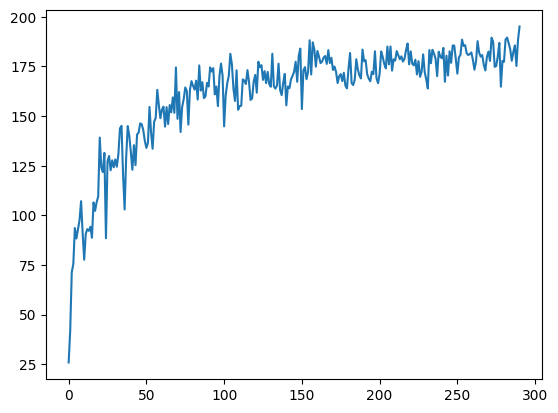

Win!


In [149]:
rewards = []
rewBuf = []
ma = -1000000000000

epsilon_decay = 0.999
min_epsilon = 0.05

for i in range(10000):
    for i in range(100):
        rewards.append(play_and_train(env,agent))
    agent.epsilon = max(min_epsilon, agent.epsilon * epsilon_decay)
    rewBuf.append(np.mean(rewards[-100:]))
    clear_output(True)
    print(agent.epsilon)
    print(rewBuf[-1])
    plt.plot(rewBuf)

    plt.show()
    if(rewBuf[-1] > 195):
        print("Win!")
        break


## 4. Experience replay (5 pts)

In [150]:
import random
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._replaceId = 0


    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize.
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        if len(self._storage) == self._maxsize:
            self._storage[self._replaceId] = data
            self._replaceId = (self._replaceId + 1) % self._maxsize
        else:
            self._storage.append(data)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """

        if len(self._storage) == 1 and batch_size == 1:
            return self._storage[0]

        idxes = [random.randrange(len(self._storage)) for _ in range(batch_size)]
        batch = [self._storage[i] for i in idxes]

        states, actions, rewards, next_states, is_done = zip(*batch)

        states = np.array(states, dtype=object)
        actions = np.array(actions, dtype=object)
        rewards = np.array(rewards, dtype=object)
        next_states = np.array(next_states, dtype=object)
        is_done = np.array(is_done, dtype=object)

        return states, actions, rewards, next_states, is_done

Some tests to make sure your buffer works right

In [151]:
import numpy as np
replay = ReplayBuffer(2)
obj1 = tuple(range(5))
obj2 = tuple(range(5, 10))
replay.add(*obj1)
assert replay.sample(1)==obj1, "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(replay._storage)==2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay._storage)==2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100))==obj2
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100))==2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100))==obj1
print ("Success!")

Success!


Now let's use this buffer to improve training:

In [152]:
import gymnasium as gym
env = Binarizer(gym.make('CartPole-v1'))
n_actions = env.action_space.n

In [153]:
agent = QLearningAgent(alpha=0.5,epsilon=0.1,discount=0.99,getLegalActions = lambda s: range(n_actions))
replay = ReplayBuffer(10000)

In [154]:
def play_and_train(env, agent, t_max=10**4, batch_size=10):
    """This function should
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s, _ = env.reset()

    for t in range(t_max):
        action = agent.getAction(s)
        next_s, r, terminated, truncated, _ = env.step(action)
        replay.add(s, action, r, next_s, terminated or truncated)
        agent.update(s, action, next_s, r)

        s = next_s
        total_reward +=r
        if terminated or truncated:
            break

    st, ac, re, nst, don = replay.sample(batch_size)
    for i in range(batch_size):
        agent.update(st[i], ac[i], nst[i], re[i])
    return total_reward

Train with experience replay

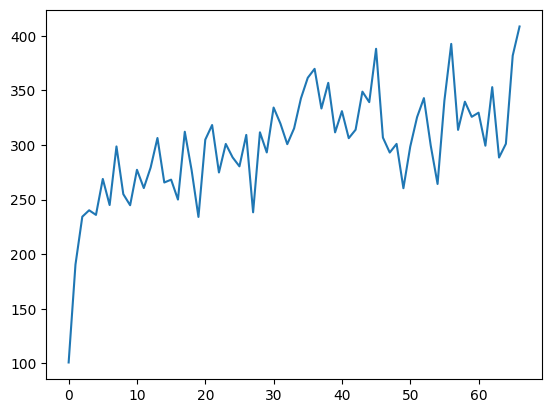

Win!


In [155]:
rewards = []
rewBuf = []
ma = -1000000000000
for i in range(10000):
    for i in range(100):
        rewards.append(play_and_train(env,agent, batch_size=1000))
    agent.epsilon *= 0.99
    rewBuf.append(np.mean(rewards[-100:]))
    clear_output(True)
    print(agent.epsilon)
    print(rewBuf[-1])
    plt.plot(rewBuf)
    plt.show()
    if(rewBuf[-1] > 400):
        print("Win!")
        break